In [1]:
#!git clone https://github.com/ndb796/bing_image_downloader

In [2]:
#!pip install opencv-contrib-python-headless

# Face Detection and Classification Model
# 1. Define Label
# 2. Download Sample Image and save into label directory
# 3. Build Resnet-18 Model ( 64 x 64 )
# 4. Split train and validation date
# 5. Train Model ( Epoch = 10 using Pretrained Resnet-18 Model )
# 6. Verification
# 7. Predict

In [3]:
import shutil
from bing_image_downloader.bing_image_downloader import downloader
from urllib.request import urlretrieve
import os, time, sys
import random
import matplotlib.pyplot as plt

import mlflow
import boto3
import cv2
import numpy as np
import glob

import keras
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Input, Flatten, MaxPooling2D, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model, load_model
import tensorflow as tf

2024-01-14 17:11:19.782888: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 17:11:19.787062: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 17:11:19.854379: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-14 17:11:19.855876: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-14 17:11:20.925896: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [4]:
auth_token = 'eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJPRE9SdWotcVYtcnNBbm9HM0loRmFJWlc3TndiQjJNWmE4UFBfMnZtcHpjIn0.eyJleHAiOjE3MDU1NzUxMzIsImlhdCI6MTcwNDk3MDMzMiwiYXV0aF90aW1lIjoxNzA0OTcwMzMyLCJqdGkiOiIyYzkwNGVhOC1hNjliLTQ1N2ItYTE1MC1iNDJiODY4NjFiMmMiLCJpc3MiOiJodHRwczovL2tleWNsb2FrLnVhLmV6bS5sb2NhbC9yZWFsbXMvVUEiLCJhdWQiOiJ1YSIsInN1YiI6ImM0Nzc5NDkwLWQ5NDUtNGRhYi1hODI5LTdhYTViZDU5N2RkNCIsInR5cCI6IklEIiwiYXpwIjoidWEiLCJub25jZSI6IlNZMHBqeFFaSUtESW5VQ1VpWkhNNGpEVVNoVVVKZ0JscmJ2akplMGNzVjAiLCJzZXNzaW9uX3N0YXRlIjoiMGQwZDJiMWUtNDVjMC00M2JhLTk3ZmItYTQ3MjhkZGEwZTJmIiwiYXRfaGFzaCI6IkwtY3dOZEV5WEc5VWhXRHBDSlFXaXciLCJhY3IiOiIxIiwic2lkIjoiMGQwZDJiMWUtNDVjMC00M2JhLTk3ZmItYTQ3MjhkZGEwZTJmIiwidWlkIjoiNjAwMiIsImVtYWlsX3ZlcmlmaWVkIjpmYWxzZSwiZ2lkIjoiNTAwNSIsIm5hbWUiOiJkZW1vIEFuUFMiLCJncm91cHMiOlsidWEtZW5hYmxlZCIsIm9mZmxpbmVfYWNjZXNzIiwiYWRtaW4iLCJ1bWFfYXV0aG9yaXphdGlvbiIsImRlZmF1bHQtcm9sZXMtdWEiXSwicHJlZmVycmVkX3VzZXJuYW1lIjoiZGVtbyIsImdpdmVuX25hbWUiOiJkZW1vIiwicG9zaXhfdXNlcm5hbWUiOiJkZW1vIiwiZmFtaWx5X25hbWUiOiJBblBTIiwiZW1haWwiOiJkZW1vQGV6dWEuY29tIn0.Ekt_F1CnYtf78rs6_NgAlqXJyjMoZOqUf6nLwg929lB0dQ7xdpwK7I2UToaHoXS2z73U3ATWD3mGU0ZQ5dR4VChJCPjocN0gRQWWyw0AjHeKzbAhTCGVKgP26HqK1VHi10SBed_q5S_n8j47_QVRBXB6ANQ3UmbmnzMLR1mJH-zaH_jDF4rlfC8UB28sMVQm8lzKBRFCJrRCfkTpoStXZ7AwnXMzDcs4c4D7O3sRMxTC-iA2rT9sFioA4Z51-PwXjk-l0g6Qw8w846winmMhP84uyIgsd4g9jqn2ZYOH9Hkl7F-pS9GdqKaNodRVKWo0SknL4RpiMJxNckrxEbQOxg'

os.environ["AWS_ACCESS_KEY_ID"]      = auth_token 
os.environ["AWS_SECRET_ACCESS_KEY"]  = "s3"
os.environ["AWS_ENDPOINT_URL"]       = 'http://local-s3-service.ezdata-system.svc.cluster.local:30000'
os.environ["MLFLOW_S3_ENDPOINT_URL"] = 'http://local-s3-service.ezdata-system.svc.cluster.local:30000'
os.environ["MLFLOW_S3_IGNORE_TLS"]   = "true"
os.environ["MLFLOW_TRACKING_INSECURE_TLS"] = "true"

config = {
    "MINIO_HOST_URL": "http://minio-service.ezdata-system.svc.cluster.local:30000",
    "MINIO_ACCESS_KEY": auth_token,
    "MINIO_SECRET_KEY": "s3",
    "KSERVE_MODEL_NAME": "face-recognition",
    "NAMESPACE": open("/var/run/secrets/kubernetes.io/serviceaccount/namespace", "r").read(),
    "BUCKET": "demo",
    "FILE_PATH": "model",
    "SERVICE_ACCOUNT": "kserve-minio-sa",
    "PROTOCOL_VERSION": "v2"
} 

experiment_name =  "Face-Recognition"
model_name = "resnet18"
model_path = os.path.join("model/",model_name)

In [5]:
def init_minio_client():
    client = boto3.client(
        service_name="s3",
        aws_access_key_id=config.get("MINIO_ACCESS_KEY"),
        aws_secret_access_key=config.get("MINIO_SECRET_KEY"),
        endpoint_url=config.get("MINIO_HOST_URL"),
        verify=False)
    return client

In [6]:
#1 Define Label
labels = ["황정민","이병헌","한석규","지진희","장동건","정우성","최민수","최민식","허준호","송강호"]
num_classes = len(labels)

image_row = 64
image_col = 64
image_color = 3
photo_shape = (image_row, image_col, image_color)

print(num_classes, photo_shape, labels)

10 (64, 64, 3) ['황정민', '이병헌', '한석규', '지진희', '장동건', '정우성', '최민수', '최민식', '허준호', '송강호']


# 학습 이미지와 라벨 다운로드

In [7]:
#2 doanload sample image and save into label directory
def download_images(photo_shape, labels, photo_npz):
    num_classes = len(labels)
    nb_sample_images = 1000
    imageDir = "./images"
    listimages = []
    listlabels = []
    cascade_filename = "./haarcascade_frontalface_alt.xml"
    cascade = cv2.CascadeClassifier(cascade_filename)
    if not os.path.exists(imageDir):
        os.mkdir(imageDir)

    for i in range(num_classes):
        label = labels[i]
        len_images = len(listimages)
        saveImageFolder = imageDir + "/" + label
        if not os.path.exists(imageDir):
            os.mkdir(imageDir)
        if not os.path.exists(saveImageFolder):
            os.mkdir(saveImageFolder)
            print(saveImageFolder, ".....downloading......")
            downloader.download(label, limit=nb_sample_images, output_dir=imageDir, adult_filter_off=True, force_replace=False, timeout=60)

        for photo in glob.glob(saveImageFolder + '/*.jpg'):
            image = cv2.imread(photo, cv2.IMREAD_UNCHANGED )           
            face_xy = cascade.detectMultiScale(image, minSize=(150,150))
            if len(face_xy) == 1:
                for (x,y,w,h) in face_xy:
                    face = image[y:y+h,x:x+w]
                    face = cv2.resize(face, (photo_shape[0], photo_shape[1]))
                    if face.shape == (photo_shape[0], photo_shape[1],photo_shape[2]):
                        listimages.append(face)
                        listlabels.append(i)
        print('Label Name : %s , Photo samples : %5.0f'%(label, len(listimages) - len_images))
    
    np.savez(photo_npz, photo=listimages, label=listlabels)
    print("Total download images : %5.0f"%(len(listimages)))
    return photo_npz
    

In [8]:
photo_npz = "./photo.npz"
if not os.path.exists(photo_npz):
    photo_npz = download_images(photo_shape, labels, photo_npz)

# Resnet-18 CNN 모델 적용

In [9]:
#3. Build Resnet-18 Model

class ResnetBlock(Model):

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [10]:
#3. Build Resnet-18 Model

model = ResNet18(num_classes=10)
model.build(input_shape = (None,64,64,3))
model.compile(optimizer = "adam",loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

AutoGraph could not transform <bound method ResnetBlock.call of <__main__.ResnetBlock object at 0x7efc5c4d27f0>> and will run it as-is.
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (Batch  multiple                  256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBloc  multiple               

In [11]:
#3. Build Resnet-18 Model
def nnModel_VGG16(image_shape, n_labels):
    images = Input(shape=image_shape, name= "Images")
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1_1')(images)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2_1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv3_1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv3_2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv4_1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv4_2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling4')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv5_1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv5_2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='Conv5_3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='Pooling5')(x)

    x = Flatten(name='Flatten')(x)
    x = Dense(4096, activation='relu', name='FC1')(x)
    x = Dense(4096, activation='relu', name='FC2')(x)
    x = Dense(n_labels, activation='softmax', name='Out')(x)

    model = Model(inputs=images, outputs=x, name='nnModel_VGG16')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
 
    return model

In [12]:
# #3. Build Resnet-18 Model
# model_name = "VGG16.keras"
# model = nnModel_VGG16(photo_shape, num_classes)


# Pre-Trained 모델 로딩

In [13]:
if os.path.exists(model_path):
    #tf.saved_model.load(model_path)
    model = tf.keras.models.load_model(model_path)
    print(f"Loading Pretrained Model . . . . . .\"{model_path}\"")


Loading Pretrained Model . . . . . ."model/resnet18"


In [14]:
#4. Split into train and validation data
photo_npz = "photo.npz"
photos = np.load(photo_npz)
photo_image = photos['photo']
photo_label = photos['label']
photo_image = photo_image.reshape(-1, photo_shape[0], photo_shape[1],photo_shape[2])
photo_image = photo_image.astype('float32') / 255
photo_label = keras.utils.to_categorical(photo_label.astype('int32'), num_classes)

X_train, X_test, Y_train, Y_test = train_test_split(photo_image, photo_label, train_size=0.8)

In [15]:
def start_run(model_name):
    now = datetime.now()
    start_run = now.strftime("%d-%b, %H:%M")
    
    if mlflow.active_run():
        mlflow.end_run()
    run = mlflow.start_run(run_name= f"Train : {start_run}")
    return run

    
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# Pre-Trained 모델 재학습 - Fine Tunning (Epoch=10)

(3408, 64, 64, 3) (853, 64, 64, 3) (3408, 10) (853, 10)
Epoch 1/10
35/35 [==============================] - 61s 1s/step - loss: 0.0825 - accuracy: 0.9765 - val_loss: 7.9429 - val_accuracy: 0.3224
Epoch 2/10
35/35 [==============================] - 45s 1s/step - loss: 0.0863 - accuracy: 0.9774 - val_loss: 4.1022 - val_accuracy: 0.5358
Epoch 3/10
35/35 [==============================] - 46s 1s/step - loss: 0.0383 - accuracy: 0.9903 - val_loss: 2.9740 - val_accuracy: 0.5451
Epoch 4/10
35/35 [==============================] - 44s 1s/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.4830 - val_accuracy: 0.8757
Epoch 5/10
35/35 [==============================] - 44s 1s/step - loss: 4.1442e-04 - accuracy: 1.0000 - val_loss: 0.0486 - val_accuracy: 0.9824
Epoch 6/10
35/35 [==============================] - 44s 1s/step - loss: 1.7198e-04 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9953
Epoch 7/10
35/35 [==============================] - 43s 1s/step - loss: 0.0030 - accuracy: 0.998

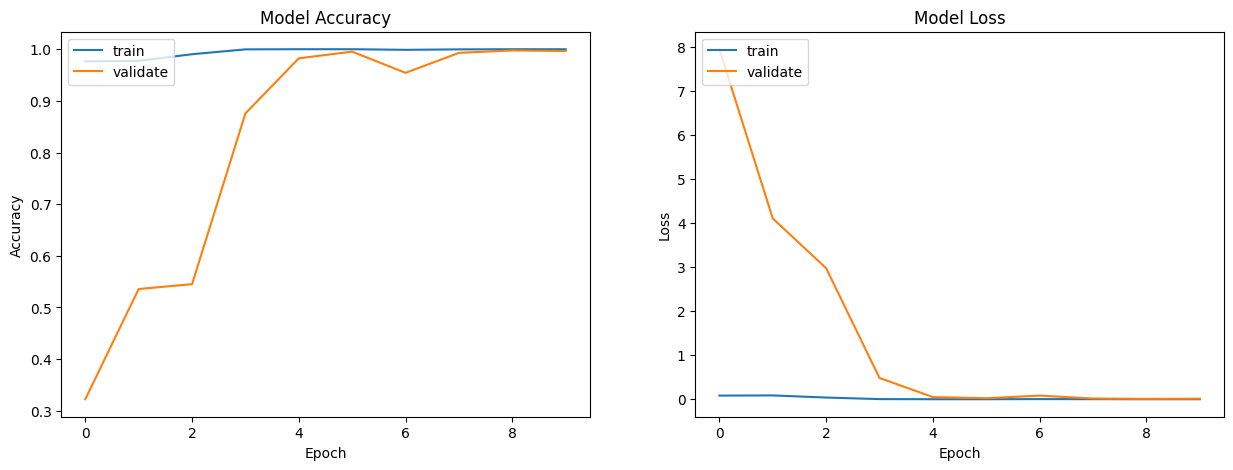

In [16]:
#5. Train Model


mlflow.set_experiment(experiment_name)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
n_epoch = 10
es = EarlyStopping(patience= 20, restore_best_weights=True, monitor="val_loss")

#I did not use cross validation, so the validate performance is not accurate.

run = start_run(model_name)
history = model.fit(X_train,Y_train,batch_size = 100, epochs=n_epoch, validation_data=(X_test, Y_test),callbacks=[es])
mlflow.log_metrics({'val_accuracy': np.mean(history.history['val_accuracy'])})
mlflow.log_metrics({'Loss': np.mean(history.history['loss'])})
mlflow.log_metrics({'val_loss': np.mean(history.history['val_loss'])})

plotmodelhistory(history)


In [17]:
print("Best run info:")
print(f"Run id: {run.info.run_id}")
model_uri = f"{run.info.artifact_uri}/{model_path}"
print(f"Run model URI: {model_uri}")
print("Service Name: ",config.get("KSERVE_MODEL_NAME"))
print("Save Model to Local Path: ",model_path)
#tf.saved_model.save(model, model_path)
tf.keras.saving.save_model(model, model_path)

print("Save Model to Remote MLFlow: ",model_uri)
mlflow.log_artifact(model_path,"model")



Best run info:
Run id: 0fd8f1ea5d1d4a32afb1e836a40c3f90
Run model URI: s3://mlflow/11/0fd8f1ea5d1d4a32afb1e836a40c3f90/artifacts/model/resnet18
Service Name:  face-recognition
Save Model to Local Path:  model/resnet18


Assets written to: model/resnet18/assets
Found credentials in environment variables.


Save Model to Remote MLFlow:  s3://mlflow/11/0fd8f1ea5d1d4a32afb1e836a40c3f90/artifacts/model/resnet18


In [18]:

manifest = f"""
apiVersion: v1
kind: Secret
metadata:
  name: s3creds
  annotations:
     serving.kserve.io/s3-endpoint: {os.environ["AWS_ENDPOINT_URL"].replace("http://", "")}
     serving.kserve.io/s3-usehttps: "0"
     serving.kserve.io/s3-useanoncredential: "false"
     serving.kserve.io/s3-cabundle: ""
type: Opaque
stringData:
  AWS_ACCESS_KEY_ID: {os.environ["AWS_ACCESS_KEY_ID"]}
  AWS_SECRET_ACCESS_KEY: {os.environ["AWS_SECRET_ACCESS_KEY"]}

---
apiVersion: v1
kind: ServiceAccount
metadata:
  name: kserve-minio-sa
secrets:
- name: s3creds

---
apiVersion: "serving.kserve.io/v1beta1"
kind: "InferenceService"
metadata:
  name: {config.get("KSERVE_MODEL_NAME")}
spec:
  predictor:
     serviceAccountName: kserve-minio-sa
     tensorflow:
       storageUri: "{model_uri}"
"""

os.makedirs("manifests", exist_ok=True)

with open(os.path.join("manifests", "isvc.yaml"), "w") as f:
    f.write(manifest)

In [19]:
DOMAIN_NAME = "svc.cluster.local"  # change this to your domain for external access
NAMESPACE = config.get("NAMESPACE")
DEPLOYMENT_NAME = config.get("KSERVE_MODEL_NAME")
MODEL_NAME = DEPLOYMENT_NAME
SVC = f'{DEPLOYMENT_NAME}-predictor-default.{NAMESPACE}.{DOMAIN_NAME}'
URL = f"https://{SVC}/v2/models/{MODEL_NAME}/infer"

print(URL)

https://face-recognition-predictor-default.demo.svc.cluster.local/v2/models/face-recognition/infer


In [20]:
# res = subprocess.run(["kubectl", "apply", "-f", "manifests/isvc.yaml"])
# print(res)

In [21]:
import gc
collected = gc.collect()
print(collected)

29789
